In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
from audio import *
import random
from fastai.callbacks import *
from IPython.core.debugger import set_trace
np.random.seed(2)
p = Config.data_path()/'freesound-audio-tagging-2019';
print(p)

/home/h/.fastai/data/freesound-audio-tagging-2019


In [3]:
# !kaggle competitions download -c freesound-audio-tagging-2019 -p {p}

In [4]:
train_path = p/'train_noisy'
valid_path = p/'train_curated'
test_path = p/'test'

213
Class: Squeak;Slam
AudioItem 3.0 seconds (132300 samples @ 44100hz)


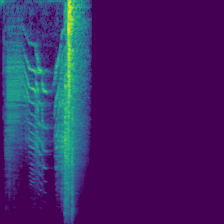

torch.Size([1, 224, 224])


In [6]:
config = AudioTransformConfig()
config.remove_silence = True
config.silence_threshold = 10
config.silence_padding = 1200
config.sg_cfg.f_max = 44100//2
# config.segment_size = 1000
# config.max_segments = 10
# config.window_size = 2000

# For 224x224 nmels = 224, hop 395
# For 128x128 hop 694 2s hop 345 1s
config.sg_cfg.n_mels = 224
config.sg_cfg.n_fft = 224*11
config.sg_cfg.hop = 224*3 -  80
config.to_db_scale = True
config.top_db = 76
config.max_to_pad = 3000
items = ItemList.from_csv(valid_path, '../train_curated.csv').split_none().label_from_df(cols='labels', label_delim=',')
carr = []
arr = []

# Get one from each class
for i in range(len(items.x)):
    if not str(items.y[i]) in carr:
        carr.append(str(items.y[i]))
        arr.append(items.x[i])

        
print(len(arr))
# DODGY: TAP (21) Church Bell(37)  Clapping (88)

def preview_tfms(idx):
    print("Class:", carr[idx])
    prevs = preview_transforms(arr[idx], valid_path, config)
    for i,y in prevs: i.show(); print(i.data.shape)
        
preview_tfms(100)

In [7]:
def _match_cond(data, cond):
    return [i for i, x in enumerate(data) if cond(x)]

def nonmulti(items):
    indexs = _match_cond(items, lambda x : len(x[1].obj)<2)
    return items[indexs]

In [8]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

In [23]:
learn = audio_learner(db, models.resnet18, metrics=[lwlrap], pretrained=False, callback_fns=[CSVLogger, ShowGraph])

In [16]:
data = AudioList.from_csv(valid_path, '../train_curated.csv', config=config).split_by_rand_pct(.3, seed=2).label_from_df(cols='labels', label_delim=',')
data.train =  nonmulti(data.train)
tfms = get_spectro_transforms(roll=True, num_cols=10, num_rows=10, tmasks=2, max_pct=.2)
db = data.transform(tfms).databunch(bs=120)
learn.data = db
db

AudioDataBunch;

Train: AudioLabelList (4073 items)
x: AudioList
AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz)
Path: /home/h/.fastai/data/freesound-audio-tagging-2019/train_curated;

Valid: AudioLabelList (2012 items)
x: AudioList
AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz),AudioItem 3.0 seconds (132300 samples @ 44100hz)
Path: /home/h/.fastai/data/freesound-audio-tagging-2019/train_curated;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


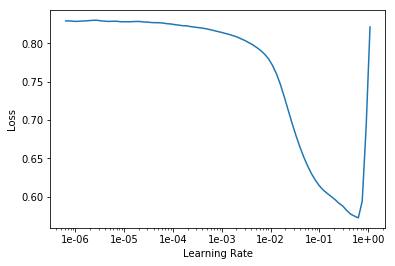

In [15]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,lwlrap,time
0,0.765952,0.748258,0.095028,00:15
1,0.705754,0.555536,0.102610,00:11
2,0.556059,0.247943,0.101219,00:11
3,0.332559,0.077170,0.140474,00:11
4,0.198304,0.085395,0.158626,00:11
5,0.130538,0.070085,0.209488,00:11
6,0.094862,0.073659,0.251270,00:11
7,0.075083,0.066522,0.288244,00:11
8,0.063347,0.069321,0.301377,00:11
9,0.055816,0.065365,0.319142,00:11


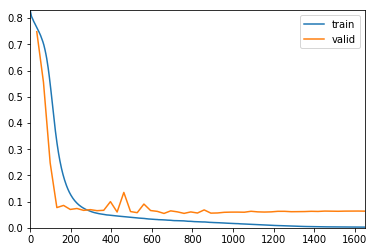

In [17]:
learn.fit_one_cycle(50, slice(1e-3, 1e-2))
learn.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


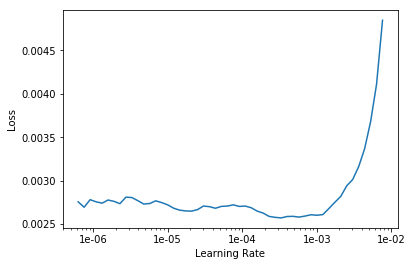

In [18]:
learn.lr_find(); learn.recorder.plot()

In [25]:
data = AudioList.from_csv(valid_path, '../train_curated.csv', config=config).split_by_rand_pct(.15, seed=2).label_from_df(cols='labels', label_delim=',')
nmulti = nonmulti(data.train)
data.train = nmulti
newitems = []

def generate_combo(pot, num=2):
    items = [deepcopy(pot[random.randint(0,len(pot)-1)]) for _ in range(num)]
    mark = "c_"+md5(''.join([str(x[0].path) for x in items]))+'.wav'
    mark = config.cache_dir / mark
    sig = sum([tfm_shift(x[0], 0.5).sig for x in items])
    raw = [x[1].raw for x in items]
    raw = sum(raw, [])
    torchaudio.save(str(mark), sig[None,:], pot[0][0].sr)
    return raw, mark


for _ in range(1000): 
    raw, mark = generate_combo(nmulti, num=random.randint(2,3))
    data.train.y.items = np.append(data.train.y.items, 0)
    data.train.y.items[-1] = list(raw)
    data.train.x.items = np.append(data.train.x.items, mark)

In [26]:
db = data.databunch(bs=120)
learn.load('stage-2')
learn.data = db
db

RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "0.4.2.conv1.weight", "0.4.2.bn1.weight", "0.4.2.bn1.bias", "0.4.2.bn1.running_mean", "0.4.2.bn1.running_var", "0.4.2.bn1.num_batches_tracked", "0.4.2.conv2.weight", "0.4.2.bn2.weight", "0.4.2.bn2.bias", "0.4.2.bn2.running_mean", "0.4.2.bn2.running_var", "0.4.2.bn2.num_batches_tracked", "0.5.2.conv1.weight", "0.5.2.bn1.weight", "0.5.2.bn1.bias", "0.5.2.bn1.running_mean", "0.5.2.bn1.running_var", "0.5.2.bn1.num_batches_tracked", "0.5.2.conv2.weight", "0.5.2.bn2.weight", "0.5.2.bn2.bias", "0.5.2.bn2.running_mean", "0.5.2.bn2.running_var", "0.5.2.bn2.num_batches_tracked", "0.5.3.conv1.weight", "0.5.3.bn1.weight", "0.5.3.bn1.bias", "0.5.3.bn1.running_mean", "0.5.3.bn1.running_var", "0.5.3.bn1.num_batches_tracked", "0.5.3.conv2.weight", "0.5.3.bn2.weight", "0.5.3.bn2.bias", "0.5.3.bn2.running_mean", "0.5.3.bn2.running_var", "0.5.3.bn2.num_batches_tracked", "0.6.2.conv1.weight", "0.6.2.bn1.weight", "0.6.2.bn1.bias", "0.6.2.bn1.running_mean", "0.6.2.bn1.running_var", "0.6.2.bn1.num_batches_tracked", "0.6.2.conv2.weight", "0.6.2.bn2.weight", "0.6.2.bn2.bias", "0.6.2.bn2.running_mean", "0.6.2.bn2.running_var", "0.6.2.bn2.num_batches_tracked", "0.6.3.conv1.weight", "0.6.3.bn1.weight", "0.6.3.bn1.bias", "0.6.3.bn1.running_mean", "0.6.3.bn1.running_var", "0.6.3.bn1.num_batches_tracked", "0.6.3.conv2.weight", "0.6.3.bn2.weight", "0.6.3.bn2.bias", "0.6.3.bn2.running_mean", "0.6.3.bn2.running_var", "0.6.3.bn2.num_batches_tracked", "0.6.4.conv1.weight", "0.6.4.bn1.weight", "0.6.4.bn1.bias", "0.6.4.bn1.running_mean", "0.6.4.bn1.running_var", "0.6.4.bn1.num_batches_tracked", "0.6.4.conv2.weight", "0.6.4.bn2.weight", "0.6.4.bn2.bias", "0.6.4.bn2.running_mean", "0.6.4.bn2.running_var", "0.6.4.bn2.num_batches_tracked", "0.6.5.conv1.weight", "0.6.5.bn1.weight", "0.6.5.bn1.bias", "0.6.5.bn1.running_mean", "0.6.5.bn1.running_var", "0.6.5.bn1.num_batches_tracked", "0.6.5.conv2.weight", "0.6.5.bn2.weight", "0.6.5.bn2.bias", "0.6.5.bn2.running_mean", "0.6.5.bn2.running_var", "0.6.5.bn2.num_batches_tracked", "0.7.2.conv1.weight", "0.7.2.bn1.weight", "0.7.2.bn1.bias", "0.7.2.bn1.running_mean", "0.7.2.bn1.running_var", "0.7.2.bn1.num_batches_tracked", "0.7.2.conv2.weight", "0.7.2.bn2.weight", "0.7.2.bn2.bias", "0.7.2.bn2.running_mean", "0.7.2.bn2.running_var", "0.7.2.bn2.num_batches_tracked". 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


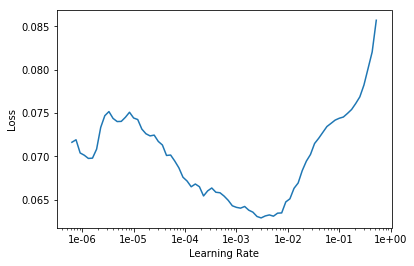

In [21]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,lwlrap,time
0,0.050499,0.056754,0.613516,00:14
1,0.040560,0.055125,0.575983,00:14
2,0.038768,0.059085,0.567347,00:14


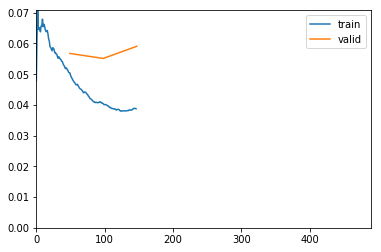

KeyboardInterrupt: 

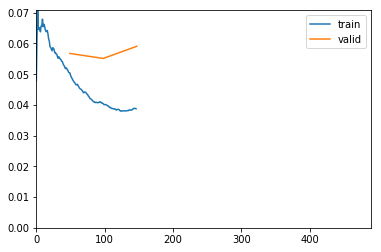

In [22]:
learn.fit_one_cycle(10, slice(1e-3, 1e-2))

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, slice(1e-6, 1e-5))

In [ ]:
test = ItemList.from_csv(test_path, '../sample_submission.csv').split_none().label_from_df()

In [ ]:
for i,l in test.train:
    ai = AudioItem.open(test_path/i)
    ai.show()
    print(audio_predict(learn, ai))